In [50]:
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit import QuantumCircuit
import numpy as np
from PIL import Image
import os, glob

In [51]:
def grid_from_png(path, rect, col_as_scalar='luminance'):
    """
    rect = (x0, y0, x1, y1) bounding the image's grid region in pixels.
    col_as_scalar: 'luminance' (default) or 'channel_r/g/b'
    Returns: (4,4) array in [0,1] after per-image min-max normalization.
    """
    img = Image.open(path).convert('RGB')
    arr = np.asarray(img, dtype=float)  # shape (H, W, 3), RGB
    H_total, W_total = arr.shape[:2]

    x0, y0, x1, y1 = rect
    # Use float cell sizes so we're accurate when W/H not multiples of 4
    cellW = (x1 - x0) / 4.0
    cellH = (y1 - y0) / 4.0

    scalars = np.zeros((4, 4), dtype=float)

    for r in range(4):
        for c in range(4):
            # center of the (r,c) cell in image coords
            x_center = x0 + (c + 0.5) * cellW
            y_center = y0 + (r + 0.5) * cellH
            # nearest pixel indices
            xi = int(round(x_center))
            yi = int(round(y_center))
            # clamp to image bounds just in case
            xi = max(0, min(W_total - 1, xi))
            yi = max(0, min(H_total - 1, yi))

            R, G, B = arr[yi, xi, 0], arr[yi, xi, 1], arr[yi, xi, 2]

            if col_as_scalar == 'luminance':
                val = 0.2126 * R + 0.7152 * G + 0.0722 * B
            elif col_as_scalar == 'channel_r':
                val = R
            elif col_as_scalar == 'channel_g':
                val = G
            elif col_as_scalar == 'channel_b':
                val = B
            else:
                raise ValueError("Unknown col_as_scalar")

            scalars[r, c] = val

    # Per-image min-max normalization to [0,1]
    m, M = scalars.min(), scalars.max()
    if M > m:
        scalars = (scalars - m) / (M - m)
    else:
        scalars[:] = 0.0

    return scalars

def pool_2x2_to_4(vec4x4):
    return np.array([
        vec4x4[0:2, 0:2].mean(),  # TL
        vec4x4[0:2, 2:4].mean(),  # TR
        vec4x4[2:4, 0:2].mean(),  # BL
        vec4x4[2:4, 2:4].mean(),  # BR
    ], dtype=float)

In [52]:
IMG_DIR = "../data/bb_jet_images"       # folder with your PNGs
ROI = (75, 75, 225, 225)           # set this manually
SAVE_4 = True                       # save pooled 4 features (4-qubit angle encode)
SAVE_16 = True                      # save all 16 cells (amplitude/reuploading)

In [53]:
pngs = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))
if not pngs:
    raise FileNotFoundError("No PNGs found in IMG_DIR")

In [54]:
X4, X16, names = [], [], []
for p in pngs:
    arr4x4 = grid_from_png(p, ROI, col_as_scalar='luminance')
    if SAVE_4:
        X4.append(pool_2x2_to_4(arr4x4))          # shape (4,)
    if SAVE_16:
        X16.append(arr4x4.flatten().astype(float)) # shape (16,)
    names.append(os.path.basename(p))

if SAVE_4:
    X4 = np.stack(X4, axis=0)
    np.save("X_4.npy", X4)            # N × 4
if SAVE_16:
    X16 = np.stack(X16, axis=0)
    np.save("X_16.npy", X16)          # N × 16

print(X4[0])

[0.   0.   0.25 0.  ]


In [55]:
def make_dataset(bb_dir, nonbb_dir, rect=(75,75,225,225), col_as_scalar='luminance'):
    xs, ys = [], []
    for p in sorted(glob.glob(os.path.join(bb_dir, "*.png"))):
        g4 = grid_from_png(p, rect, col_as_scalar)
        xs.append(pool_2x2_to_4(g4))   # -> 4 features
        ys.append(+1)                  # bb => +1
    for p in sorted(glob.glob(os.path.join(nonbb_dir, "*.png"))):
        g4 = grid_from_png(p, rect, col_as_scalar)
        xs.append(pool_2x2_to_4(g4))
        ys.append(-1)                  # non-bb => -1 (to match your example)
    X = np.stack(xs, axis=0).astype(float)  # (N, 4)
    y = np.array(ys, dtype=int)             # (N,)
    return X, y

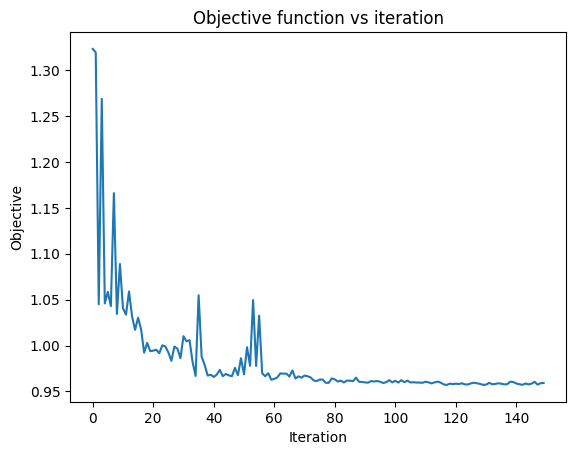

Train accuracy: 56.43%
Test accuracy : 57.00%
First 9 preds: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [56]:
from qcnn.model import qcnn
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ----- build dataset -----
bb_dir   = "../data/bb_jet_images"       # <-- change to your folder
nonbb_dir= "../data/nonb_jet_images"    # <-- change to your folder
X, y = make_dataset(bb_dir, nonbb_dir, rect=(75,75,225,225), col_as_scalar='luminance')

# train/test split
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.3, random_state=246, stratify=y
)

# ----- build QCNN (4 inputs => 4 qubits) -----
width, height = 2, 2
circuit, qnn = qcnn(width * height)  # your qcnn factory

# optional: visualize circuit
# circuit.draw("mpl", style="clifford")

# ----- training -----
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function vs iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=150),
    callback=callback_graph,
    warm_start=True,  # allows continuing from last weights in same session
)

# Fit
classifier.fit(train_X, train_y)

# Evaluate
train_acc = 100 * classifier.score(train_X, train_y)
test_acc  = 100 * classifier.score(test_X, test_y)
print(f"Train accuracy: {train_acc:.2f}%")
print(f"Test accuracy : {test_acc:.2f}%")

# Save model
classifier.save("bb_qcnn_classifier.model")

# Predict some examples
y_pred = classifier.predict(test_X[:9])
print("First 9 preds:", y_pred)
